In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.svm import SVC
from collections import OrderedDict

Load the training database into pandas and split the survived column

In [2]:
training = pd.read_csv('data/train.csv')
training_survived = np.array(training.Survived)

Lets explore it

In [3]:
training.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


## Preprocessing the training dataset ##

In [5]:
training_age_mean = training['Age'].mean()
print(training_age_mean)

29.69911764705882


In [6]:
training_embarked_counts = training['Embarked'].value_counts()
print(training_embarked_counts)
print("Most frequent embarked: ", training_embarked_counts.idxmax())

S    644
C    168
Q     77
Name: Embarked, dtype: int64
Most frequent embarked:  S


As we can see the dataset contains columns that dont give us any useful information for classify supervivence such as Name, Cabin, PassangerId, and Ticket so we remove them.
Also the dataset contains bunch of null values in columns Age and Embarked. Either for Age and Embarked, one option could be remove those rows, and the other option is filling with invented data based on some statistics/interpolation over that columns. Since there are a lot of nulls in Age column if we remove that rows we are going to loose a lot of data for trainining (19% of training data). Because of that, I choose the second option filling null columns with the mean of non-null values for columns Age as we calculated before (29 years). For Embarked column becouse this is a categorical one so we replace the null values with the most frecuent label as we calculated before (the 'S' label) with `value_counts`.

In [7]:
del training['Name']
del training['Cabin']
del training['PassengerId']
del training['Ticket']
training['Age'] = training['Age'].fillna(training_age_mean)
training['Embarked'] = training['Embarked'].fillna(training_embarked_counts.idxmax())

In [8]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Sex         891 non-null object
Age         891 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    891 non-null object
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


### Extraction of feature vectors ###

For training the classifiers first we have to turn categorical columns into numerical features. For this we are going to use one-hot vector scheme that maps each category with a vector with one in some index and zero in the rest.
For example:

'S' -> (1,0,0).
'C' -> (0,1,0).
'Q' -> (0,0,1).

This task is acomplished with LabelBinarizer from scikit-learn. For LabelBinarizer to build automatically that mapping we need to fit their corresponding columns of the training data. We keep this transformations becouse for the test dataset we want to use the same scheme.

In [9]:
pclass_transf   = LabelBinarizer().fit(training['Pclass'])
sex_tranf       = LabelBinarizer().fit(training['Sex'])
sibsp_transf    = LabelBinarizer().fit(training['SibSp'])
parch_transf    = LabelBinarizer().fit(training['Parch'])
embarked_transf = LabelBinarizer().fit(training['Embarked'])

Finally we transform each feature to get this vectors, and concatenate them in one big vector feature vector. Doing this for every row we finish with a matrix of feature vectors were each row represents a feature. Becouse we have to do the same thing with the test database and using the same binarizer functions already fitted (pclass_transform, sex_transf, etc) its useful to turning this procedure into a function so we can reuse it for the test dataset.

In [10]:
def get_feature_vectors(df):
    age_vec = np.array(df['Age']).reshape(-1, 1)
    fare_vec = np.array(df['Fare']).reshape(-1,1)
    pclass_vec = pclass_transf.transform(df['Pclass'])
    sex_vec = sex_tranf.transform(df['Sex'])
    sibsp_vec = sibsp_transf.transform(df['SibSp'])
    parch_vec = parch_transf.transform(df['Parch'])
    embarked_vec = embarked_transf.transform(df['Embarked'])
    
    data_values = np.concatenate((age_vec,
                                  fare_vec, 
                                  sex_vec,
                                  sibsp_vec,
                                  parch_vec,
                                  embarked_vec,
                                  pclass_vec),
                                 axis=1)
    return data_values

training_features = get_feature_vectors(training)

Because the feature vectors hasn't a nice distribution of values to make easier to the models to train we want to normalize this data over the entire set of examples shifting the mean to zero and variance to one. This is done by the StandardScaler class. So we fit the scaler to the data and then transformed it with fit_transform

In [11]:
normalizer = StandardScaler()
training_features = normalizer.fit_transform(training_features)

### Classifier models ###

Now lets compite some machine learning models

In [12]:
clfs = OrderedDict(
       {'2-NN' : KNeighborsClassifier(n_neighbors=2),
        '5-NN' : KNeighborsClassifier(n_neighbors=5),
        '10-NN' : KNeighborsClassifier(n_neighbors=10),
        'DecisionTree' : tree.DecisionTreeClassifier(),
        'RandomForest (20 estimators)' : RandomForestClassifier(n_estimators=20),
        'RandomForest (50 estimators)' : RandomForestClassifier(n_estimators=50),
        'Perceptron simple' : MLPClassifier(solver='sgd', activation='relu', hidden_layer_sizes=(), max_iter=3000),
        '2-Layers MLP (100 H)' : MLPClassifier(solver='sgd', activation='relu', hidden_layer_sizes=(100), max_iter=3000),
        '3-Layers MLP (200 H -> 100 H)' : MLPClassifier(solver='sgd', activation='relu', hidden_layer_sizes=(200, 100), max_iter=3000),
        'SVM' : SVC(),
       })

### Training the classifiers ###

In [13]:
training_accuracies = []
test_accuracies = []

for name, clf in clfs.items():
    clf.fit(training_features, training_survived)
    accuracy_training = accuracy_score(clf.predict(training_features), training_survived) * 100
    training_accuracies.append(accuracy_training)

In [14]:
test = pd.read_csv('data/test.csv')
test_survived = pd.read_csv('data/gender_submission.csv')['Survived']

In [15]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [16]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [17]:
del test['Name']
del test['Cabin']
del test['PassengerId']
del test['Ticket']
test['Age'] = test['Age'].fillna(test['Age'].mean())
test['Fare'] = test['Fare'].fillna(test['Fare'].mean())

In [18]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
Pclass      418 non-null int64
Sex         418 non-null object
Age         418 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Fare        418 non-null float64
Embarked    418 non-null object
dtypes: float64(2), int64(3), object(2)
memory usage: 22.9+ KB


In [19]:
test_features = normalizer.transform(get_feature_vectors(test))

In [20]:
for name, clf in clfs.items():
    accuracy_test = accuracy_score(clf.predict(test_features), test_survived) * 100
    test_accuracies.append(accuracy_test)

## Score metrics ##

Lets load test dataset first

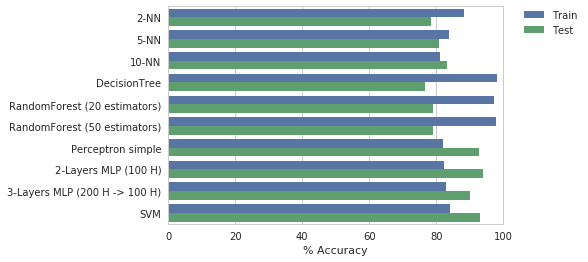

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

f, ax = plt.subplots()

accuracies = pd.DataFrame({'name' : list(clfs.keys()) * 2, 
                           'accuracy' : training_accuracies + test_accuracies, 
                           'mode' : ['Train'] * len(training_accuracies) + ['Test'] * len(test_accuracies)})

sns.barplot(x="accuracy", y="name", hue='mode', data=accuracies)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set(xlim=(0, 100), ylabel="",
       xlabel="% Accuracy")
plt.show()

In [29]:
table = OrderedDict()

for name, clf in clfs.items():
    tn, fp, fn, tp = confusion_matrix(clf.predict(test_features), test_survived).ravel()
    n = len(test)
    table[name] = {
                   '% de Aciertos' : (tp+tn)/n * 100.0,
                   '% de Verdaderos Positivos': tp/n * 100.0,
                   '% de Verdaderos Negativos': tn/n * 100.0,
                   '% de Fallos' : (fn+fp)/n * 100.0,
                   '% de Falsos Negativos' : fn/n * 100.0,
                   '% de Falsos Positivos' : fn/n * 100.0,
                   'Precision' : tp/(tp+fp),
                   'Recall' : tp/(tp+fn),
                   }
                  
                     
pd.DataFrame().from_dict(table, orient='index').sort_values(by=['% de Aciertos'], ascending=False)

,% de Aciertos,% de Verdaderos Positivos,% de Verdaderos Negativos,% de Fallos,% de Falsos Negativos,% de Falsos Positivos,Precision,Recall
2-Layers MLP (100 H),94.019139,33.253589,60.765550,5.980861,2.870813,2.870813,0.914474,0.920530
SVM,93.062201,32.775120,60.287081,6.937799,3.349282,3.349282,0.901316,0.907285
Perceptron simple,92.822967,33.492823,59.330144,7.177033,4.306220,4.306220,0.921053,0.886076
3-Layers MLP (200 H -> 100 H),90.191388,31.339713,58.851675,9.808612,4.784689,4.784689,0.861842,0.867550
10-NN,83.253589,26.794258,56.459330,16.746411,7.177033,7.177033,0.736842,0.788732
5-NN,80.861244,27.751196,53.110048,19.138756,10.526316,10.526316,0.763158,0.725000
RandomForest (50 estimators),79.186603,25.119617,54.066986,20.813397,9.569378,9.569378,0.690789,0.724138
RandomForest (20 estimators),78.947368,24.162679,54.784689,21.052632,8.851675,8.851675,0.664474,0.731884
2-NN,78.468900,19.377990,59.090909,21.531100,4.545455,4.545455,0.532895,0.810000
DecisionTree,76.794258,24.162679,52.631579,23.205742,11.004785,11.004785,0.664474,0.687075


In [ ]:
confusion_table_dataframe(clf)

In [23]:
best_classifiers = accuracies[accuracies['mode'] == 'Test'].sort_values(['accuracy'], ascending=False)[:4]['name']
best_classifiers = {name : clfs[name] for name in best_classifiers}

In [24]:
best_classifiers

{'2-Layers MLP (100 H)': MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
        beta_2=0.999, early_stopping=False, epsilon=1e-08,
        hidden_layer_sizes=100, learning_rate='constant',
        learning_rate_init=0.001, max_iter=3000, momentum=0.9,
        nesterovs_momentum=True, power_t=0.5, random_state=None,
        shuffle=True, solver='sgd', tol=0.0001, validation_fraction=0.1,
        verbose=False, warm_start=False),
 '3-Layers MLP (200 H -> 100 H)': MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
        beta_2=0.999, early_stopping=False, epsilon=1e-08,
        hidden_layer_sizes=(200, 100), learning_rate='constant',
        learning_rate_init=0.001, max_iter=3000, momentum=0.9,
        nesterovs_momentum=True, power_t=0.5, random_state=None,
        shuffle=True, solver='sgd', tol=0.0001, validation_fraction=0.1,
        verbose=False, warm_start=False),
 'Perceptron simple': MLPClassifier(activation='relu', alp

In [25]:
predictions = OrderedDict({model_name : clf.predict(test_features) for model_name, clf in clfs.items()})

In [33]:
from collections import Counter

best_predictions = []
for test_feature in test_features:
    clfs_predictions = Counter()
    for clf in best_classifiers.values():
        clfs_predictions[clf.predict(test_feature.reshape(1,-1))[0]] += 1
    best_predictions.append(clfs_predictions.most_common()[0][0])

In [34]:
accuracy_score(np.array(best_predictions), test_survived)

0.9425837320574163

In [41]:
tn, fp, fn, tp = confusion_matrix(np.array(best_predictions), test_survived).ravel()
n = len(test)
table['Baggin'] = {'% de Aciertos' : (tp+tn)/n * 100.0,
                   '% de Verdaderos Positivos': tp/n * 100.0,
                   '% de Verdaderos Negativos': tn/n * 100.0,
                   '% de Fallos' : (fn+fp)/n * 100.0,
                   '% de Falsos Negativos' : fn/n * 100.0,
                   '% de Falsos Positivos' : fn/n * 100.0,
                   'Precision' : tp/(tp+fp),
                   'Recall' : tp/(tp+fn)}
pd.DataFrame().from_dict(table, orient='index').sort_values(by=['% de Aciertos'], ascending=False)

,% de Aciertos,% de Verdaderos Positivos,% de Verdaderos Negativos,% de Fallos,% de Falsos Negativos,% de Falsos Positivos,Precision,Recall
Baggin,94.258373,33.492823,60.765550,5.741627,2.870813,2.870813,0.921053,0.921053
2-Layers MLP (100 H),94.019139,33.253589,60.765550,5.980861,2.870813,2.870813,0.914474,0.920530
SVM,93.062201,32.775120,60.287081,6.937799,3.349282,3.349282,0.901316,0.907285
Perceptron simple,92.822967,33.492823,59.330144,7.177033,4.306220,4.306220,0.921053,0.886076
3-Layers MLP (200 H -> 100 H),90.191388,31.339713,58.851675,9.808612,4.784689,4.784689,0.861842,0.867550
10-NN,83.253589,26.794258,56.459330,16.746411,7.177033,7.177033,0.736842,0.788732
5-NN,80.861244,27.751196,53.110048,19.138756,10.526316,10.526316,0.763158,0.725000
RandomForest (50 estimators),79.186603,25.119617,54.066986,20.813397,9.569378,9.569378,0.690789,0.724138
RandomForest (20 estimators),78.947368,24.162679,54.784689,21.052632,8.851675,8.851675,0.664474,0.731884
2-NN,78.468900,19.377990,59.090909,21.531100,4.545455,4.545455,0.532895,0.810000
